In [27]:
import os

output_folder = "/Users/Jayee/Library/CloudStorage/OneDrive-UW-Madison/PhD(my_PC)/\
PhD(output_files)/Engineering_projects/Shear_loading/240712_GPR_NODE/700/TDD/applying_GPR_with_noise"


Till now we obtained the histograms and the datas corresponding moments. We are interested in interpolating the moments using GPR. 

Note that there are two odd points in the moments. the 5th data point in skewness and 6th data point in Kutosis.

In [8]:
mom_scaler_list

[MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()]

0
1
2
3


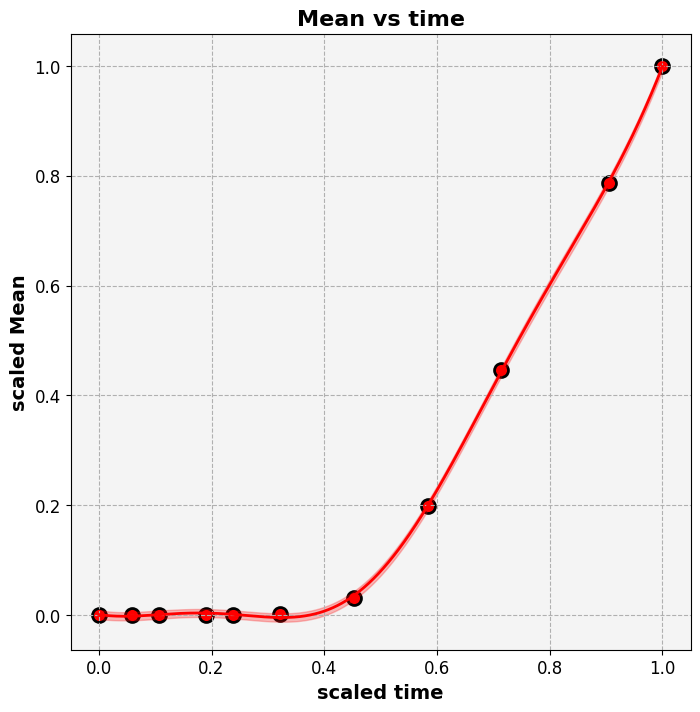

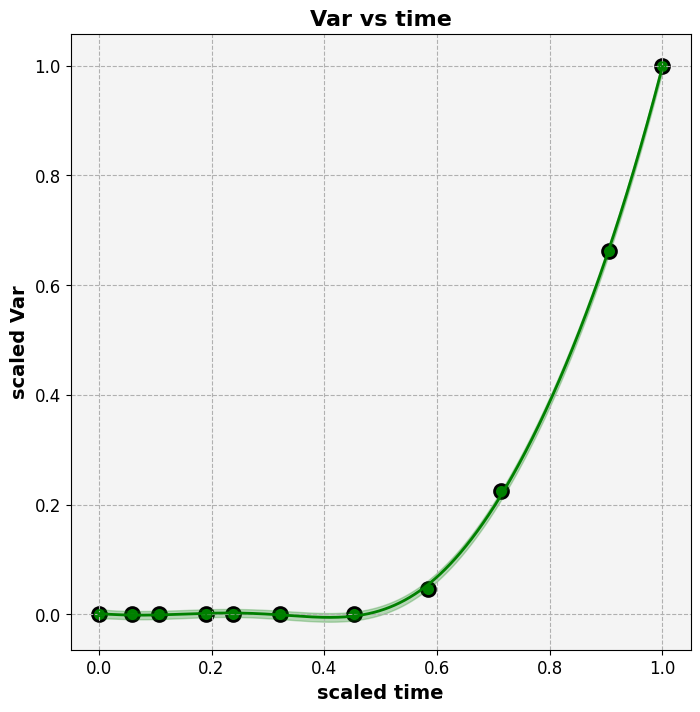

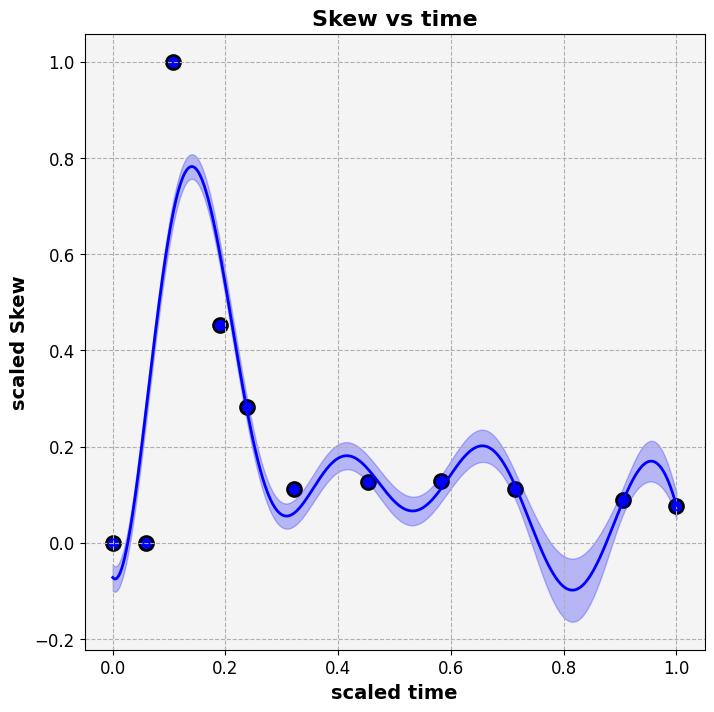

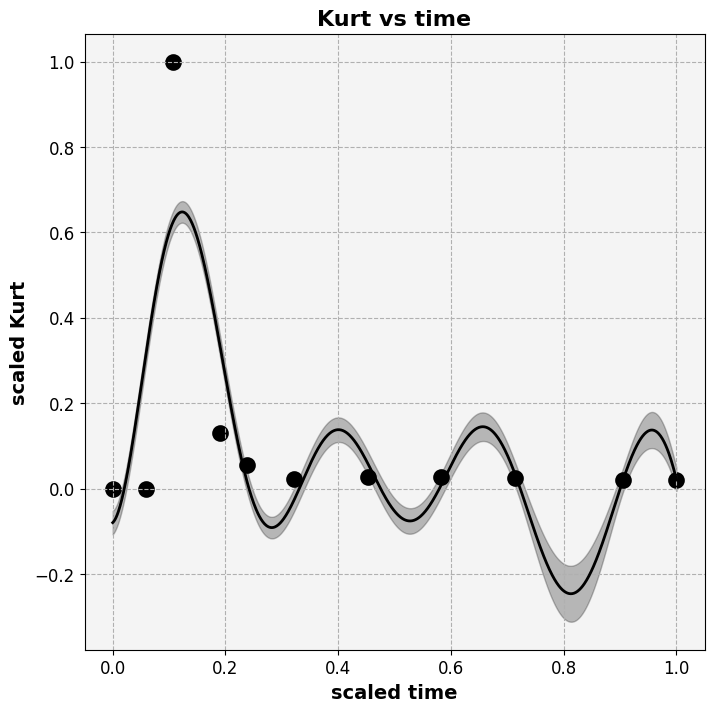

In [62]:
# All libraries being used will be at the start of the code
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
import matplotlib.pyplot as plt

# Loading the input file
input_file = "/Volumes/Extreme SSD/mac_data/shear_data/tdd_data/700/moments_tdd/t_mvskm5m6_700.npy"
tmvsk = np.load(input_file)

# Let us concentrate on just the first 4 moments
## Therefore we let us delete the last two columns of the array
tmvsk = tmvsk[:,:5]

# Preparing 4 sets of data for GPR
## [t,m], [t,v], [t,s], [t,k] 
### dummy initialization
data_sets = [[0,0] for _ in range(4)]

# deleting the 5th data point in skewness and 6th data point in kurtosis
s_column_index = 3 #Skewness belongs to 4th column in tmvsk
s_del_index = 4 #5th point needs ro be removed
k_column_index = 4 ##kurtosis belongs to 5th column in tmvsk
k_del_index = 5 #6th point needs to be removed
for _ in range(4):
    if _ == 7:
        data_sets[_] = [np.delete(tmvsk[:,0],s_del_index).reshape(-1,1),
                        np.delete(tmvsk[:,s_column_index],s_del_index).reshape(-1,1)]
    elif _ == 7:
        data_sets[_] = [np.delete(tmvsk[:,0],k_del_index).reshape(-1,1),
                        np.delete(tmvsk[:,k_column_index],k_del_index).reshape(-1,1)]
    else:
        data_sets[_] = [(tmvsk[:,0]).reshape(-1,1),(tmvsk[:,_+1]).reshape(-1,1)]
    print(_)

# Scaling the data
## There are 4 t scalers and 1 of each of m,v,s,k scalers.
## Scaling and saving the scalers of m,v,s,k is important for Neural ODE.
scaled_data_sets = []
t_scalers_list = [MinMaxScaler() for _ in range(4)]
mom_scaler_list = [MinMaxScaler() for _ in range(4)]
len_scale_list = []

len_scale_factor = np.array([2,2,1,1])
noise_level_list = [1e-5,1e-5,1e-4,1e-4]

# for 700 data von mises stress
# len_scale_factor = np.array([2,2,1.2,1.5])
# noise_level_list = [1e-5,1e-5,1e-3,1e-5]

# for 701 data von mises stress
# len_scale_factor = np.array([1.32,1.32,1.32,1.2])
# noise_level_list = [1e-5,1e-5,1e-5,1e-5]

for _,scaled_data_set in enumerate(data_sets):
    # Fitting the scaler
    t_scalers_list[_].fit(scaled_data_set[0])
    mom_scaler_list[_].fit(scaled_data_set[1])
    # Scaling the data
    scaled_data_set[0] = t_scalers_list[_].transform(scaled_data_set[0])
    scaled_data_set[1] =  mom_scaler_list[_].transform(scaled_data_set[1])
    scaled_data_sets.append(scaled_data_set)
    time_intervals = scaled_data_set[0][1:] - scaled_data_set[0][:-1]
    # Defining the length scales for each of the data set.
    len_scale_list.append(max(time_intervals))


# Defining the kernels
kernel_list = [RBF(length_scale=len_scale_list[_]*len_scale_factor[_],
                  length_scale_bounds = len_scale_list[_]*np.array([0.85,1.32]))
               + WhiteKernel(noise_level=noise_level_list[_])
               for _ in range(4)]

# Defining GP Regressors
gpr_list = [GPR(kernel = kernel_list[_],
                n_restarts_optimizer = 10,
               optimizer=None,
               random_state=1) for _ in range(4)]
#gpr.max_iter_pred

# Learning and predicting with gpr
t_plot = np.linspace(0,1,1000).reshape(-1,1)
mean_pred_list = []
std_pred_list = []
for _,scaled_data_set in enumerate(scaled_data_sets):
    gpr_list[_].fit(scaled_data_set[0],scaled_data_set[1])
    mean_pred,std_pred = gpr_list[_].predict(t_plot,return_std=True)
    mean_pred_list.append(mean_pred)
    std_pred_list.append(std_pred)
    
[m_gpr,v_gpr,s_gpr,k_gpr]=gpr_list
mom_names_list = ["Mean","Var","Skew","Kurt"]
color_list = ["red","green","blue","black"]
shape_list = ["o", "^","v","s"]

# Visualizing the results:
# Defining important variables.
imp_vars = {"name":mom_names_list,
            "model":gpr_list,
            "m_scale":mom_scaler_list,
            "t_scale":t_scalers_list,
            "color":color_list,
            "sds":scaled_data_sets,
            "t_plot":np.transpose(t_plot)[0],
            "mean":mean_pred_list,
            "std":std_pred_list
           }
# Defining a plot function
def my_plot(imp_vars):
    # we have to have 4 plots
    for _ in range(4):
        fig,axs = plt.subplots(1,1,figsize=[8,8])
        axs.set_xlabel("scaled time", fontweight="bold", fontsize=14)
        axs.set_ylabel(f"scaled {imp_vars['name'][_]}", fontsize=14, fontweight="bold")
        axs.set_title(f"{imp_vars['name'][_]} vs time",fontsize=16, fontweight="bold" )
        axs.set_facecolor("#f4f4f4")
        axs.grid(linestyle = "--")
        axs.tick_params(labelsize = 12)
        
        # Plotting the ground truth
        axs.scatter(imp_vars["sds"][_][0],imp_vars["sds"][_][1],
                    c=imp_vars["color"][_],
                    s=100,
                    edgecolor="k",linewidths=2,
                 label = f"scaled acual {imp_vars['name'][_]}")
        # plotting the GPR mean
        axs.plot(imp_vars["t_plot"],imp_vars["mean"][_],
                 color=imp_vars["color"][_],linestyle="-",linewidth=2,
                 label = f"scaled acual {imp_vars['name'][_]}")
        # Plotting the GPR std
        axs.fill_between(imp_vars["t_plot"],
                         imp_vars["mean"][_]+1.96*imp_vars["std"][_],
                         imp_vars["mean"][_]-1.96*imp_vars["std"][_],
                        color =imp_vars["color"][_],
                        alpha=0.25)
        # Saving the file
        file_name = f"{_}_{imp_vars['name'][_]}_GPR_with_noise.pdf"
        file_loc = os.path.join(output_folder,file_name)
        plt.savefig(file_loc)

my_plot(imp_vars)

In [17]:
file_name = "imp_vars_TDD_700.pkl"
file_loc = os.path.join(output_folder,file_name)
file_loc

'/Users/Jayee/Library/CloudStorage/OneDrive-UW-Madison/PhD(my_PC)/PhD(output_files)/Engineering_projects/Shear_loading/240712_701_data/700/240712_applying_GPR_with_noise/important_variables_700.pkl'

In [18]:
# Saving the varibles.
import pickle
file_name = "important_variables_700.pkl"
file_loc = os.path.join(output_folder,file_name)
# Save the dictionary to a pickle file
with open(file_loc, 'wb') as pickle_file:
    pickle.dump(imp_vars, pickle_file)

# Load the dictionary from the pickle file
with open(file_loc, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

print(loaded_data)


{'name': ['Mean', 'Var', 'Skew', 'Kurt'], 'model': [GaussianProcessRegressor(kernel=RBF(length_scale=0.381) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=10, optimizer=None,
                         random_state=1), GaussianProcessRegressor(kernel=RBF(length_scale=0.381) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=10, optimizer=None,
                         random_state=1), GaussianProcessRegressor(kernel=RBF(length_scale=0.229) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=10, optimizer=None,
                         random_state=1), GaussianProcessRegressor(kernel=RBF(length_scale=0.286) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=10, optimizer=None,
                         random_state=1)], 'm_scale': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], 't_scale': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '